In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, models, transforms
from PIL import Image
import time
import copy # To copy model weights
from tqdm import tqdm # For progress bars

# Check for GPU availability and set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 5080


In [11]:
# --- Configuration ---
# !! Adjust these paths if needed, relative to your notebook !!
# This assumes your data is in: ../data/archive/data/train/infected and ../data/archive/data/train/notinfected
# ImageFolder expects a structure like: data_dir/class_name/image.xxx
# So we point data_dir to the parent of 'infected' and 'notinfected'
data_dir = '../data/archive/data/train' # Check this path carefully!

# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 25 # Start with fewer epochs (e.g., 10-15) and increase if needed

# --- Image Transformations ---
# Define transforms for training (with augmentation) and validation/testing (no augmentation)
# Using standard ImageNet normalization values as a starting point
image_size = 224 # ResNet and many others expect 224x224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(10), # Optional augmentation
        # transforms.ColorJitter(brightness=0.2, contrast=0.2), # Optional augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # If you have a separate test set, use 'val' transforms for it too
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [12]:
# Cell 3 (Corrected): Load Data, Split, Create DataLoaders

# --- Create Datasets and DataLoaders ---

# Use ImageFolder WITHOUT initial transforms to load PIL Images
try:
    full_dataset_pil = datasets.ImageFolder(data_dir, transform=None) # Load as PIL images
    class_names = full_dataset_pil.classes
    print("Classes found:", class_names)
    print("Class to index mapping:", full_dataset_pil.class_to_idx)
    print("Total images found:", len(full_dataset_pil))

    # Split into Training and Validation (e.g., 80/20 split)
    train_size = int(0.8 * len(full_dataset_pil))
    val_size = len(full_dataset_pil) - train_size
    # Use the PIL dataset for splitting
    train_subset_pil, val_subset_pil = random_split(full_dataset_pil, [train_size, val_size], generator=torch.Generator().manual_seed(42))

    # Custom Dataset wrapper to apply transforms ON THE FLY
    class CustomSubsetWithTransform(Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform # Store the appropriate transform pipeline

        def __getitem__(self, index):
            # Get PIL image and label from the original subset
            x, y = self.subset[index]
            # Apply transforms HERE before returning
            if self.transform:
                x = self.transform(x)
            return x, y

        def __len__(self):
            return len(self.subset)

    # Create the final datasets by wrapping the PIL subsets with the appropriate transforms
    train_dataset = CustomSubsetWithTransform(train_subset_pil, transform=data_transforms['train'])
    val_dataset = CustomSubsetWithTransform(val_subset_pil, transform=data_transforms['val'])


    # Create DataLoaders (Keep num_workers=0 for now)
    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
        'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    }
    dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

    print(f"\nTraining set size: {dataset_sizes['train']}")
    print(f"Validation set size: {dataset_sizes['val']}")
    data_loading_successful = True

except FileNotFoundError:
    print(f"Error: Data directory not found at {data_dir}")
    print("Please ensure the 'data_dir' variable points to the directory containing 'infected' and 'notinfected' subfolders.")
    data_loading_successful = False
except Exception as e:
     print(f"An error occurred during data loading: {e}")
     data_loading_successful = False

Classes found: ['infected', 'notinfected']
Class to index mapping: {'infected': 0, 'notinfected': 1}
Total images found: 1924

Training set size: 1539
Validation set size: 385


In [13]:
# --- Model Definition ---
# Load a pre-trained ResNet model (e.g., ResNet18 or ResNet50)
model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1) # Load pre-trained weights

# Freeze all layers except the final classification layer
# for param in model_ft.parameters():
#     param.requires_grad = False  # Optional: Freeze layers for faster initial training

# Get the number of input features for the final layer
num_ftrs = model_ft.fc.in_features

# Replace the final layer for our binary classification task
# Output 2 units: one for each class ('infected', 'notinfected')
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Move the model to the designated device (GPU or CPU)
model_ft = model_ft.to(device)

print("--- Model Defined (ResNet18 base) ---")
# print(model_ft) # Optional: Print model structure

--- Model Defined (ResNet18 base) ---


In [14]:
# --- Loss and Optimizer ---
criterion = nn.CrossEntropyLoss() # Suitable for multi-class (even if only 2) output with raw scores

# Observe that all parameters are being optimized (or only fc if frozen)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate)

# Optional: Learning rate scheduler
# Decay LR by a factor of 0.1 every 7 epochs
# scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

print("--- Loss function and optimizer defined ---")

--- Loss function and optimizer defined ---


In [15]:
# --- Training Loop Function ---
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Use tqdm for progress bar over batches
            dataloader_with_progress = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch+1}/{num_epochs}')

            # Iterate over data.
            for inputs, labels in dataloader_with_progress:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Update tqdm description with running loss/acc
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                dataloader_with_progress.set_postfix({'Loss': f'{epoch_loss:.4f}', 'Acc': f'{epoch_acc:.4f}'})


            # # Optional: Step the learning rate scheduler
            # if phase == 'train' and scheduler:
            #      scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item()) # Store as float

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it's the best validation accuracy so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'*** Best validation Acc so far: {best_acc:.4f} ***')


        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [16]:
# --- Test DataLoader Iteration ---
if data_loading_successful:
  print("Attempting to load one batch from training dataloader...")
  try:
      test_data_iter = iter(dataloaders['train'])
      inputs, labels = next(test_data_iter)
      print(f"Successfully loaded one batch! Input shape: {inputs.shape}")
      # Optional: Test moving to device
      # inputs = inputs.to(device)
      # labels = labels.to(device)
      # print("Successfully moved batch to device.")
  except Exception as e:
      print(f"Error loading batch: {e}")
      import traceback
      traceback.print_exc() # Print more details if an error occurs here
else:
    print("Skipping dataloader test as data loading failed earlier.")

Attempting to load one batch from training dataloader...
Successfully loaded one batch! Input shape: torch.Size([32, 3, 224, 224])


In [17]:
# --- Start Training ---
# Only run if data loading was successful
if data_loading_successful:
    model_ft, history = train_model(model_ft, criterion, optimizer_ft, num_epochs=num_epochs)
    # Save the best model weights if needed
    # torch.save(model_ft.state_dict(), 'pcos_resnet18_best.pth')
    # print("Best model weights saved.")
else:
    print("Skipping training because data loading failed.")

Epoch 1/25
----------


Train Epoch 1/25: 100%|██████████| 49/49 [00:04<00:00, 11.20it/s, Loss=0.1551, Acc=0.9448]


Train Loss: 0.1551 Acc: 0.9448


Val Epoch 1/25: 100%|██████████| 13/13 [00:00<00:00, 13.68it/s, Loss=0.0020, Acc=1.0000]


Val Loss: 0.0020 Acc: 1.0000
*** Best validation Acc so far: 1.0000 ***

Epoch 2/25
----------


Train Epoch 2/25: 100%|██████████| 49/49 [00:03<00:00, 13.23it/s, Loss=0.0870, Acc=0.9662]


Train Loss: 0.0870 Acc: 0.9662


Val Epoch 2/25: 100%|██████████| 13/13 [00:00<00:00, 14.66it/s, Loss=0.0081, Acc=1.0000]


Val Loss: 0.0081 Acc: 1.0000

Epoch 3/25
----------


Train Epoch 3/25: 100%|██████████| 49/49 [00:03<00:00, 13.13it/s, Loss=0.0367, Acc=0.9877]


Train Loss: 0.0367 Acc: 0.9877


Val Epoch 3/25: 100%|██████████| 13/13 [00:00<00:00, 14.88it/s, Loss=0.1118, Acc=0.9636]


Val Loss: 0.1118 Acc: 0.9636

Epoch 4/25
----------


Train Epoch 4/25: 100%|██████████| 49/49 [00:03<00:00, 13.49it/s, Loss=0.1026, Acc=0.9636]


Train Loss: 0.1026 Acc: 0.9636


Val Epoch 4/25: 100%|██████████| 13/13 [00:00<00:00, 14.64it/s, Loss=0.0063, Acc=1.0000]


Val Loss: 0.0063 Acc: 1.0000

Epoch 5/25
----------


Train Epoch 5/25: 100%|██████████| 49/49 [00:03<00:00, 13.46it/s, Loss=0.1422, Acc=0.9584]


Train Loss: 0.1422 Acc: 0.9584


Val Epoch 5/25: 100%|██████████| 13/13 [00:00<00:00, 15.09it/s, Loss=3.8392, Acc=0.5065]


Val Loss: 3.8392 Acc: 0.5065

Epoch 6/25
----------


Train Epoch 6/25: 100%|██████████| 49/49 [00:03<00:00, 13.40it/s, Loss=0.0465, Acc=0.9792]


Train Loss: 0.0465 Acc: 0.9792


Val Epoch 6/25: 100%|██████████| 13/13 [00:00<00:00, 14.69it/s, Loss=0.0076, Acc=1.0000]


Val Loss: 0.0076 Acc: 1.0000

Epoch 7/25
----------


Train Epoch 7/25: 100%|██████████| 49/49 [00:03<00:00, 13.34it/s, Loss=0.0365, Acc=0.9903]


Train Loss: 0.0365 Acc: 0.9903


Val Epoch 7/25: 100%|██████████| 13/13 [00:00<00:00, 15.08it/s, Loss=0.0258, Acc=0.9922]


Val Loss: 0.0258 Acc: 0.9922

Epoch 8/25
----------


Train Epoch 8/25: 100%|██████████| 49/49 [00:03<00:00, 13.22it/s, Loss=0.0694, Acc=0.9766]


Train Loss: 0.0694 Acc: 0.9766


Val Epoch 8/25: 100%|██████████| 13/13 [00:00<00:00, 14.27it/s, Loss=0.0424, Acc=0.9870]


Val Loss: 0.0424 Acc: 0.9870

Epoch 9/25
----------


Train Epoch 9/25: 100%|██████████| 49/49 [00:03<00:00, 13.39it/s, Loss=0.0600, Acc=0.9818]


Train Loss: 0.0600 Acc: 0.9818


Val Epoch 9/25: 100%|██████████| 13/13 [00:00<00:00, 14.20it/s, Loss=0.0041, Acc=1.0000]


Val Loss: 0.0041 Acc: 1.0000

Epoch 10/25
----------


Train Epoch 10/25: 100%|██████████| 49/49 [00:03<00:00, 13.26it/s, Loss=0.0181, Acc=0.9935]


Train Loss: 0.0181 Acc: 0.9935


Val Epoch 10/25: 100%|██████████| 13/13 [00:00<00:00, 14.47it/s, Loss=0.0029, Acc=1.0000]


Val Loss: 0.0029 Acc: 1.0000

Epoch 11/25
----------


Train Epoch 11/25: 100%|██████████| 49/49 [00:03<00:00, 12.49it/s, Loss=0.0325, Acc=0.9896]


Train Loss: 0.0325 Acc: 0.9896


Val Epoch 11/25: 100%|██████████| 13/13 [00:00<00:00, 13.01it/s, Loss=0.1833, Acc=0.9247]


Val Loss: 0.1833 Acc: 0.9247

Epoch 12/25
----------


Train Epoch 12/25: 100%|██████████| 49/49 [00:03<00:00, 12.34it/s, Loss=0.1088, Acc=0.9623]


Train Loss: 0.1088 Acc: 0.9623


Val Epoch 12/25: 100%|██████████| 13/13 [00:00<00:00, 13.10it/s, Loss=0.0379, Acc=0.9792]


Val Loss: 0.0379 Acc: 0.9792

Epoch 13/25
----------


Train Epoch 13/25: 100%|██████████| 49/49 [00:03<00:00, 12.35it/s, Loss=0.0464, Acc=0.9818]


Train Loss: 0.0464 Acc: 0.9818


Val Epoch 13/25: 100%|██████████| 13/13 [00:01<00:00, 12.56it/s, Loss=0.0054, Acc=1.0000]


Val Loss: 0.0054 Acc: 1.0000

Epoch 14/25
----------


Train Epoch 14/25: 100%|██████████| 49/49 [00:03<00:00, 12.41it/s, Loss=0.0420, Acc=0.9864]


Train Loss: 0.0420 Acc: 0.9864


Val Epoch 14/25: 100%|██████████| 13/13 [00:00<00:00, 13.63it/s, Loss=0.0032, Acc=1.0000]


Val Loss: 0.0032 Acc: 1.0000

Epoch 15/25
----------


Train Epoch 15/25: 100%|██████████| 49/49 [00:03<00:00, 12.53it/s, Loss=0.0298, Acc=0.9903]


Train Loss: 0.0298 Acc: 0.9903


Val Epoch 15/25: 100%|██████████| 13/13 [00:00<00:00, 13.44it/s, Loss=0.0002, Acc=1.0000]


Val Loss: 0.0002 Acc: 1.0000

Epoch 16/25
----------


Train Epoch 16/25: 100%|██████████| 49/49 [00:03<00:00, 12.44it/s, Loss=0.0642, Acc=0.9773]


Train Loss: 0.0642 Acc: 0.9773


Val Epoch 16/25: 100%|██████████| 13/13 [00:00<00:00, 13.39it/s, Loss=0.0019, Acc=1.0000]


Val Loss: 0.0019 Acc: 1.0000

Epoch 17/25
----------


Train Epoch 17/25: 100%|██████████| 49/49 [00:03<00:00, 12.30it/s, Loss=0.0546, Acc=0.9818]


Train Loss: 0.0546 Acc: 0.9818


Val Epoch 17/25: 100%|██████████| 13/13 [00:00<00:00, 13.48it/s, Loss=0.0009, Acc=1.0000]


Val Loss: 0.0009 Acc: 1.0000

Epoch 18/25
----------


Train Epoch 18/25: 100%|██████████| 49/49 [00:03<00:00, 12.50it/s, Loss=0.0315, Acc=0.9922]


Train Loss: 0.0315 Acc: 0.9922


Val Epoch 18/25: 100%|██████████| 13/13 [00:00<00:00, 13.25it/s, Loss=0.0005, Acc=1.0000]


Val Loss: 0.0005 Acc: 1.0000

Epoch 19/25
----------


Train Epoch 19/25: 100%|██████████| 49/49 [00:03<00:00, 12.43it/s, Loss=0.0145, Acc=0.9961]


Train Loss: 0.0145 Acc: 0.9961


Val Epoch 19/25: 100%|██████████| 13/13 [00:00<00:00, 13.30it/s, Loss=0.0003, Acc=1.0000]


Val Loss: 0.0003 Acc: 1.0000

Epoch 20/25
----------


Train Epoch 20/25: 100%|██████████| 49/49 [00:03<00:00, 12.34it/s, Loss=0.0269, Acc=0.9909]


Train Loss: 0.0269 Acc: 0.9909


Val Epoch 20/25: 100%|██████████| 13/13 [00:00<00:00, 13.30it/s, Loss=0.0159, Acc=0.9922]


Val Loss: 0.0159 Acc: 0.9922

Epoch 21/25
----------


Train Epoch 21/25: 100%|██████████| 49/49 [00:03<00:00, 12.53it/s, Loss=0.1008, Acc=0.9708]


Train Loss: 0.1008 Acc: 0.9708


Val Epoch 21/25: 100%|██████████| 13/13 [00:00<00:00, 13.03it/s, Loss=0.0534, Acc=0.9792]


Val Loss: 0.0534 Acc: 0.9792

Epoch 22/25
----------


Train Epoch 22/25: 100%|██████████| 49/49 [00:03<00:00, 12.50it/s, Loss=0.0573, Acc=0.9825]


Train Loss: 0.0573 Acc: 0.9825


Val Epoch 22/25: 100%|██████████| 13/13 [00:00<00:00, 13.29it/s, Loss=0.0054, Acc=0.9948]


Val Loss: 0.0054 Acc: 0.9948

Epoch 23/25
----------


Train Epoch 23/25: 100%|██████████| 49/49 [00:03<00:00, 12.44it/s, Loss=0.0506, Acc=0.9825]


Train Loss: 0.0506 Acc: 0.9825


Val Epoch 23/25: 100%|██████████| 13/13 [00:00<00:00, 13.39it/s, Loss=0.0100, Acc=0.9974]


Val Loss: 0.0100 Acc: 0.9974

Epoch 24/25
----------


Train Epoch 24/25: 100%|██████████| 49/49 [00:04<00:00, 12.23it/s, Loss=0.0763, Acc=0.9753]


Train Loss: 0.0763 Acc: 0.9753


Val Epoch 24/25: 100%|██████████| 13/13 [00:00<00:00, 13.24it/s, Loss=0.0395, Acc=0.9792]


Val Loss: 0.0395 Acc: 0.9792

Epoch 25/25
----------


Train Epoch 25/25: 100%|██████████| 49/49 [00:03<00:00, 12.43it/s, Loss=0.0491, Acc=0.9857]


Train Loss: 0.0491 Acc: 0.9857


Val Epoch 25/25: 100%|██████████| 13/13 [00:00<00:00, 13.19it/s, Loss=0.0034, Acc=1.0000]

Val Loss: 0.0034 Acc: 1.0000

Training complete in 2m 0s
Best val Acc: 1.000000


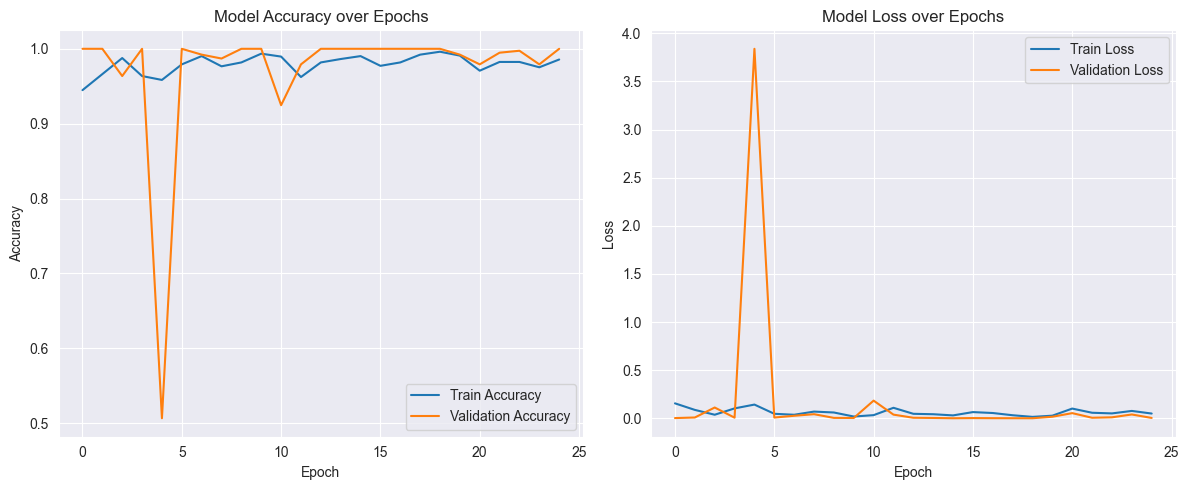

In [18]:
# --- Plot Training History ---
if data_loading_successful and history:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("Skipping plotting as training did not occur or history is missing.")


--- Evaluating on Validation Set using Best Model Weights ---


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.60it/s]


Classification Report (Validation Set):

              precision    recall  f1-score   support

    infected       1.00      1.00      1.00       160
 notinfected       1.00      1.00      1.00       225

    accuracy                           1.00       385
   macro avg       1.00      1.00      1.00       385
weighted avg       1.00      1.00      1.00       385


Confusion Matrix (Validation Set):

[[160   0]
 [  0 225]]


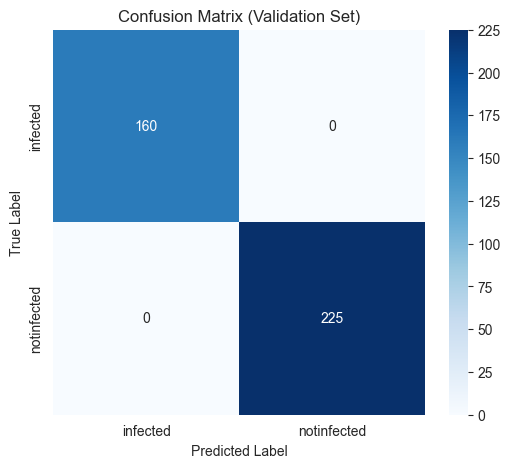

In [19]:
# --- Evaluation ---
# You would ideally have a separate test set loader here.
# For now, we'll re-evaluate on the validation set with the best weights loaded.
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, dataloader):
    model.eval() # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad(): # No need to track gradients
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds


if data_loading_successful:
    print("\n--- Evaluating on Validation Set using Best Model Weights ---")
    true_labels, predicted_labels = evaluate_model(model_ft, dataloaders['val'])

    print("\nClassification Report (Validation Set):\n")
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    print("\nConfusion Matrix (Validation Set):\n")
    cm = confusion_matrix(true_labels, predicted_labels)
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Validation Set)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("Skipping evaluation as training did not occur.")

In [22]:
# Cell: Pre-filter Test Images
import os
from torchvision import datasets
from PIL import Image, UnidentifiedImageError # Import specific error
from tqdm import tqdm
import torch # Make sure torch is imported

# Define path for the TEST data
test_data_dir = '../data/archive/data/test' # Directory containing 'infected' and 'notinfected' test subfolders

print(f"\n--- Scanning for valid images in: {test_data_dir} ---")
pre_filtering_done = False
valid_samples = []
class_names = [] # Will get this from temp dataset

# Use ImageFolder just to easily get all samples (path, class_idx)
try:
    # Create a temporary dataset to get file list and classes
    # Use minimal default transform to avoid issues here if any file causes transform errors
    temp_dataset = datasets.ImageFolder(test_data_dir)
    all_samples = temp_dataset.samples # List of (filepath, class_index) tuples
    class_names = temp_dataset.classes # Get class names ['infected', 'notinfected']
    print(f"Found {len(all_samples)} total files listed.")
    print(f"Classes found: {class_names}")

    invalid_files_count = 0
    for path, class_idx in tqdm(all_samples, desc="Checking images"):
        try:
            # Try to open and load the image to ensure it's valid
            with Image.open(path) as img:
                img.load() # Attempt to load image data
            # If successful, add to our list of valid samples
            valid_samples.append((path, class_idx))
        except (UnidentifiedImageError, FileNotFoundError, OSError, IOError) as e:
            # Catch common image loading errors and skip the file
            # print(f"Skipping invalid file: {path} - {e}") # Optional: uncomment to see skipped files
            invalid_files_count += 1

    print(f"\nScan complete.")
    print(f"Found {len(valid_samples)} valid images.")
    if invalid_files_count > 0:
        print(f"Skipped {invalid_files_count} invalid files.")
    pre_filtering_done = True

except FileNotFoundError:
    print(f"Error: Test data directory not found at {test_data_dir}")
except Exception as e:
    print(f"An error occurred during scanning: {e}")

# Now you should have 'valid_samples' (list of (path, class_idx) for good images)
# and 'class_names' available for the next cell.


--- Scanning for valid images in: ../data/archive/data/test ---
Found 1932 total files listed.
Classes found: ['infected', 'notinfected']


Checking images: 100%|██████████| 1932/1932 [00:01<00:00, 1572.69it/s]


Scan complete.
Found 1922 valid images.
Skipped 10 invalid files.


In [23]:
# Cell: Define Test Loader (Using Pre-filtered Data)
# Ensure 'Dataset', 'DataLoader', 'data_transforms', 'batch_size' exist from previous cells
# Ensure necessary libraries (torch, PIL) are imported

# --- Create Test Dataset and DataLoader using pre-filtered list ---

print(f"\n--- Creating TEST dataset using {len(valid_samples)} pre-validated images ---")

# Custom Dataset class that takes the list of valid samples
class ValidatedImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples # List of (filepath, class_index) tuples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, label = self.samples[index]
        try:
            # Open image, convert to RGB (important for pre-trained models)
            img = Image.open(path).convert('RGB')
            # Apply transforms if they exist
            if self.transform:
                img = self.transform(img)
            return img, label
        except Exception as e:
            # Should ideally not happen often now, but good to have a fallback
            print(f"Error loading/transforming presumably valid file {path}: {e}. Skipping.")
            # Return None or handle appropriately; maybe return placeholder?
            # Returning None requires a custom collate_fn in DataLoader to handle it.
            # For simplicity now, let's re-raise, but ideally handle more gracefully.
            raise e


if pre_filtering_done and valid_samples:
    try:
        # Create test dataset using the valid samples and 'test' transforms
        test_dataset = ValidatedImageDataset(valid_samples, transform=data_transforms['test'])
        print(f"Successfully created test dataset with {len(test_dataset)} images.")

        # Create test DataLoader (no shuffle needed)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0) # Keep num_workers=0
        print("Successfully created test DataLoader.")
        test_data_loading_successful = True

    except Exception as e:
        print(f"Error creating test dataset/dataloader from valid samples: {e}")
        test_data_loading_successful = False
else:
    print("\nSkipping Test DataLoader creation as pre-filtering failed or found no valid samples.")
    test_data_loading_successful = False


--- Creating TEST dataset using 1922 pre-validated images ---
Successfully created test dataset with 1922 images.
Successfully created test DataLoader.



--- Evaluating CNN on Actual Test Set ---


Evaluating: 100%|██████████| 61/61 [00:04<00:00, 13.37it/s]


Classification Report (Test Set):

              precision    recall  f1-score   support

    infected       1.00      1.00      1.00       781
 notinfected       1.00      1.00      1.00      1141

    accuracy                           1.00      1922
   macro avg       1.00      1.00      1.00      1922
weighted avg       1.00      1.00      1.00      1922


Confusion Matrix (Test Set):

[[ 781    0]
 [   0 1141]]


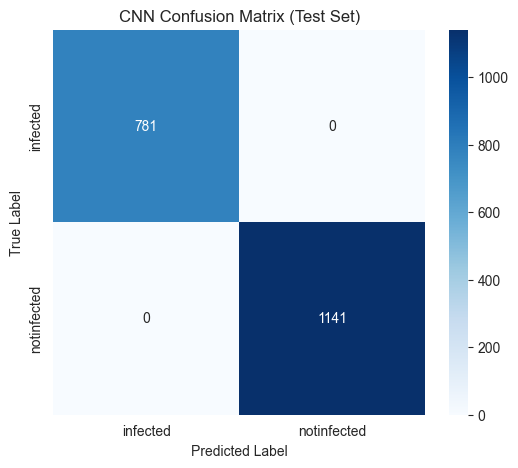

In [24]:
# Ensure 'model_ft' (with best weights loaded), 'device', 'evaluate_model' function,
# 'class_names', 'classification_report', 'confusion_matrix', 'sns', 'plt' exist

if test_data_loading_successful:
    print("\n--- Evaluating CNN on Actual Test Set ---")
    # IMPORTANT: Ensure 'model_ft' contains the weights from the best validation epoch

    # Use the evaluation function defined earlier
    true_labels_test, predicted_labels_test = evaluate_model(model_ft, test_loader)

    print("\nClassification Report (Test Set):\n")
    # Ensure class_names is defined correctly from your training setup
    print(classification_report(true_labels_test, predicted_labels_test, target_names=class_names))

    print("\nConfusion Matrix (Test Set):\n")
    cm_test = confusion_matrix(true_labels_test, predicted_labels_test)
    print(cm_test)

    # Plot Confusion Matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('CNN Confusion Matrix (Test Set)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("\nSkipping test set evaluation for CNN model as test data loading failed.")